In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import proplot as pplt
import scipy.signal as sig
from scipy.stats import pearsonr

from pyISV.utils import remove_partial_year, calc_anomalies, calc_lanczos_filtered_anomalies
from pyISV.metrics import index_agreement, root_mean_squared_error, r2_score

#### Enter latitude and longitude bounds of the domain and slice the OLR within the domain
Check for NaNs. The input data should not contain NaNs. Replace the NaNs if present.

In [2]:
lat_south, lat_north, long_west, long_east = -7.5, 7.5, 125, 270

#### Get the years to split the dataset into training, validation, and testing. 

In [3]:
startTrain, endTrain, startVal, endVal, startTest, endTest = '1988', '2012', '2013', '2014', '2015', '2016'

#### Load the blended surface zonal wind stress data.
The dataset is described here (Lybarger et al. 2020): https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JC016732

In [4]:
# Load precomputed blended daily mean zonal wind stress anomalies
tauxa = xr.open_dataset('blended.taux.anom.nc').taux.sel(lat=slice(lat_south,lat_north),
                                                         lon=slice(long_west,long_east)).sel(time=slice(startTest, endTest))
# Load pre-computed 30-90-day Lanczos filtered anomalies
taux_bpf = xr.open_dataset('blended.tauxi.nc').taux.sel(lat=slice(lat_south,lat_north),
                                                        lon=slice(long_west,long_east)).sel(time=slice(startTest, endTest)) 
# Fill the missing values with the values to the nearest longitude
# Raw data has missing values at 180 longitude
tauxa[:,:,110] = tauxa[:,:,109]
tauxa[:,:,111] = tauxa[:,:,112]
taux_bpf[:,:,110] = taux_bpf[:,:,109] 
taux_bpf[:,:,111] = taux_bpf[:,:,112]

#### Load interpolated NOAA OLR 
The interpolated OLR data is downloaded from: \
https://downloads.psl.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc \
For convenince, OLR file is renamed.

In [5]:
# NOAA interpolated daily mean OLR
olriFile = 'olr.day.interpolated.mean.nc'
olri = xr.open_dataset(olriFile).olr
olri = olri.reindex(lat=olri.lat[::-1])
olri = olri.sel(lat=slice(lat_south,lat_north),lon=slice(long_west,long_east),time=slice('1980',None))

#### Calculate climatology, anomalies, and 30-90-day band pass filtered OLR anomalies
Calculate climatology based only on the training period.

In [6]:
nwgths, tpa, tpb, filt_type  = 90, 30, 90, 'band' # The filter uses 181 (nwgths*2+1) weights; tpa, tpb: Time period

olri_anom, _ = calc_anomalies(olri, startTrain, endTrain, smooth_climatology=False)
olri_bpf = calc_lanczos_filtered_anomalies(olri_anom, nwgths, filt_type, tpa, tpb)

# Select the same time period for the unfiltered anomalies as the filtered anomalies
olri_anom = olri_anom.sel(time=slice(olri_bpf.time[0], olri_bpf.time[-1]))

# Remove the partial year data
olri_bpf = remove_partial_year(olri_bpf)
olri_anom = remove_partial_year(olri_anom)

#### Regrid taux to match with the dimension of OLR.

In [7]:
### Regridding the zonal wind stress to match with OLR spatial resolution
tauxa = tauxa.interp(lon=olri_anom.lon,lat=olri_anom.lat)
taux_bpf = taux_bpf.interp(lon=olri_anom.lon,lat=olri_anom.lat)

olri_anom = olri_anom.sel(time=slice(startTest, endTest))
olri_bpf = olri_bpf.sel(time=slice(startTest, endTest))

#### Load the CNN filtered OLR and taux
The files 'olr.cnn.bpf.nc' and 'taux.cnn.bpf.nc' are generated by the main code OLR.1dCNN.ipynb and WS.1dCNN.ipynb

In [8]:
olricnn = xr.open_dataset('olr.cnn.bpf.nc').olr
tauxicnn = xr.open_dataset('taux.cnn.bpf.nc').taux

# Interpolate the grid to match with OLR
tauxicnn = tauxicnn.interp(lon=olri_anom.lon,lat=olri_anom.lat)

#### Latitudinal average and difference between Lanczos and CNN filtered 30-90-day anomalies.

In [9]:
## Zonal Wind Stress
tauxa_meanlat = tauxa.mean('lat')
tauxi_meanlat_lan = taux_bpf.mean('lat')
tauxi_meanlat_cnn = tauxicnn.mean('lat')
tauxi_diff = tauxi_meanlat_lan - tauxi_meanlat_cnn
## OLR
olra_meanlat = olri_anom.mean('lat')
olri_meanlat_lan = olri_bpf.mean('lat')
olri_meanlat_cnn = olricnn.mean('lat')
olri_diff = olri_meanlat_lan - olri_meanlat_cnn
### create dates to replace with noleap calendar dates in taux
dates = pd.date_range(start="2015-01-01",end="2016-12-31")
dates = dates[~((dates.month == 2) & (dates.day == 29))]
tauxa_meanlat['time'] = dates
tauxi_meanlat_lan['time'] = dates
tauxi_meanlat_cnn['time'] = dates
tauxi_diff['time'] = dates

#### Figure 3a

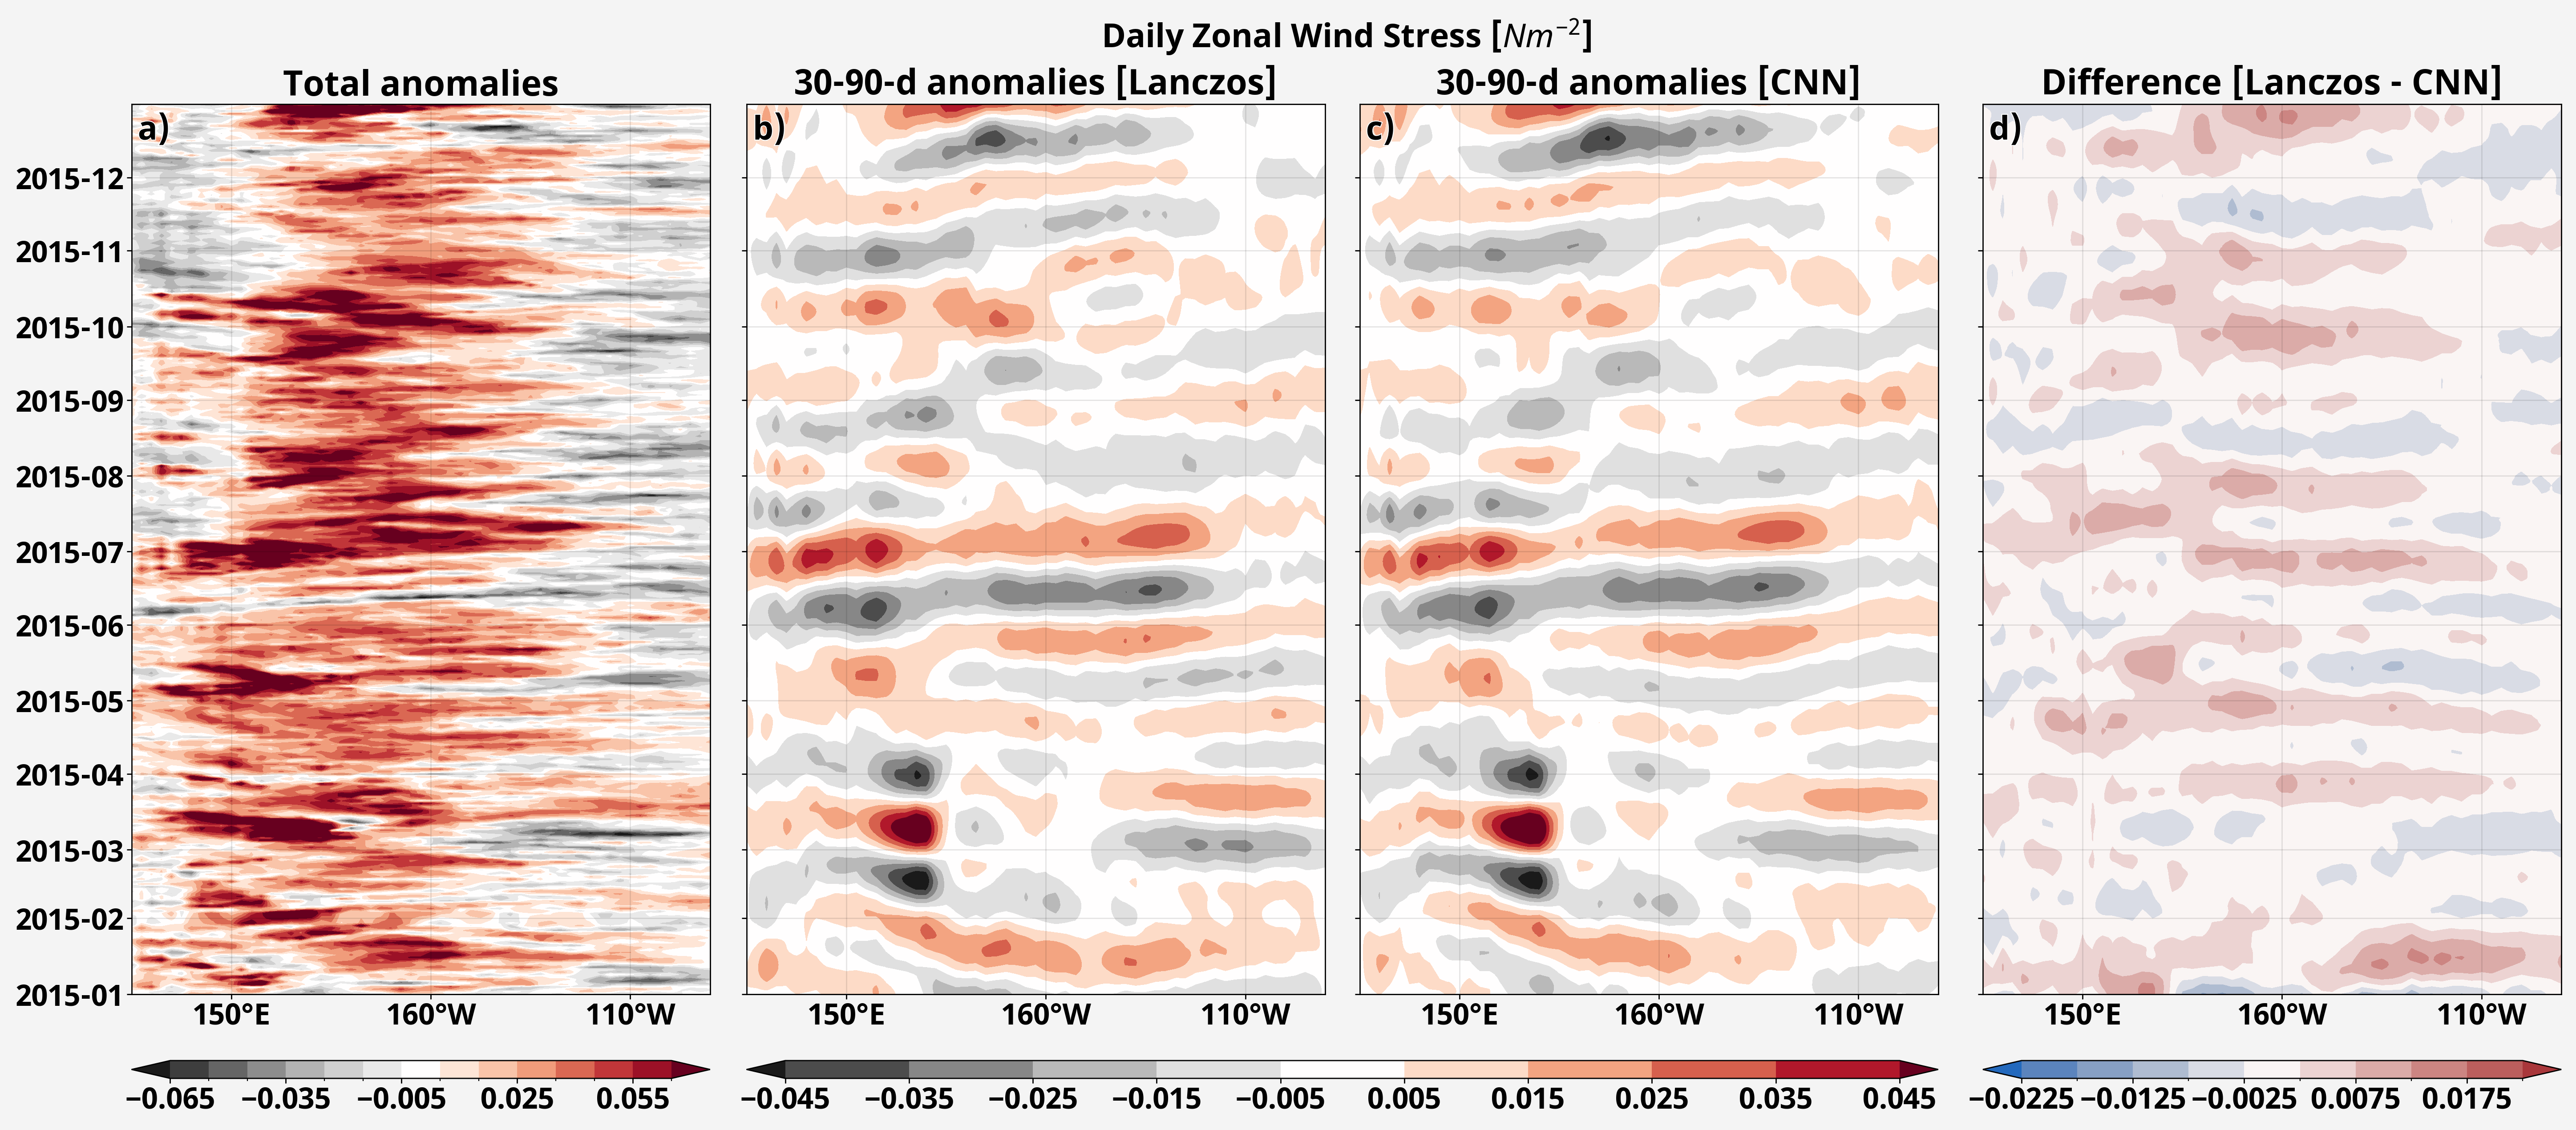

In [10]:
levels1 = [-0.065,-0.055,-0.045,-0.035,-0.025,-0.015,-0.005,0.005,0.015,0.025,0.035,0.045,0.055,0.065]
levels2 = [-0.045,-0.035,-0.025,-0.015,-0.005,0.005,0.015,0.025,0.035,0.045]
levels3 = [-0.0225,-0.0175,-0.0125,-0.0075,-0.0025,0.0025,0.0075,0.0125,0.0175,0.0225]

pplt.rc.update({'meta.width':1,'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':24,'titlesize':28})

fig, axs = pplt.subplots(nrows=1,ncols=4,tight=True,refwidth=6.5,refheight=10)
axs.format(xlabel='',ylabel='',xformatter='deglon',xlocator=50,xtickminor=False,ytickminor=False,abc='a)',abcloc='ul')

vmin = tauxa_meanlat.sel(time=slice('2015','2015')).max().values
im1 = axs[0].contourf(tauxa_meanlat.sel(time=slice('2015','2015')),levels=levels1,extend='both',cmap='RdGy_r',colorbar=False)
im2 = axs[1].contourf(tauxi_meanlat_lan.sel(time=slice('2015','2015')),levels=levels2,extend='both',cmap='RdGy_r',colorbar=False)
axs[2].contourf(tauxi_meanlat_cnn.sel(time=slice('2015','2015')),levels=levels2,extend='both',cmap='RdGy_r',colorbar=False)
im3 = axs[3].contourf(tauxi_diff.sel(time=slice('2015','2015')),levels=levels3,extend='both',cmap='Vlag',colorbar=False)

axs[0].format(title='Total anomalies')
axs[1].format(title='30-90-d anomalies [Lanczos]')
axs[2].format(title='30-90-d anomalies [CNN]')
axs[3].format(title='Difference [Lanczos - CNN]')

fig.colorbar(im1,location='bottom',shrink= 1, width= 0.2,label='',col=1)
fig.colorbar(im2,location='bottom',shrink= 1, width= 0.2,label='',col=(2,3))
fig.colorbar(im3,location='bottom',shrink= 1, width= 0.2,label='',col=4)
fig.suptitle(r'Daily Zonal Wind Stress [$Nm^{-2}$]');

fig.savefig('Fig3a.png',dpi=150)

#### Figure 3b

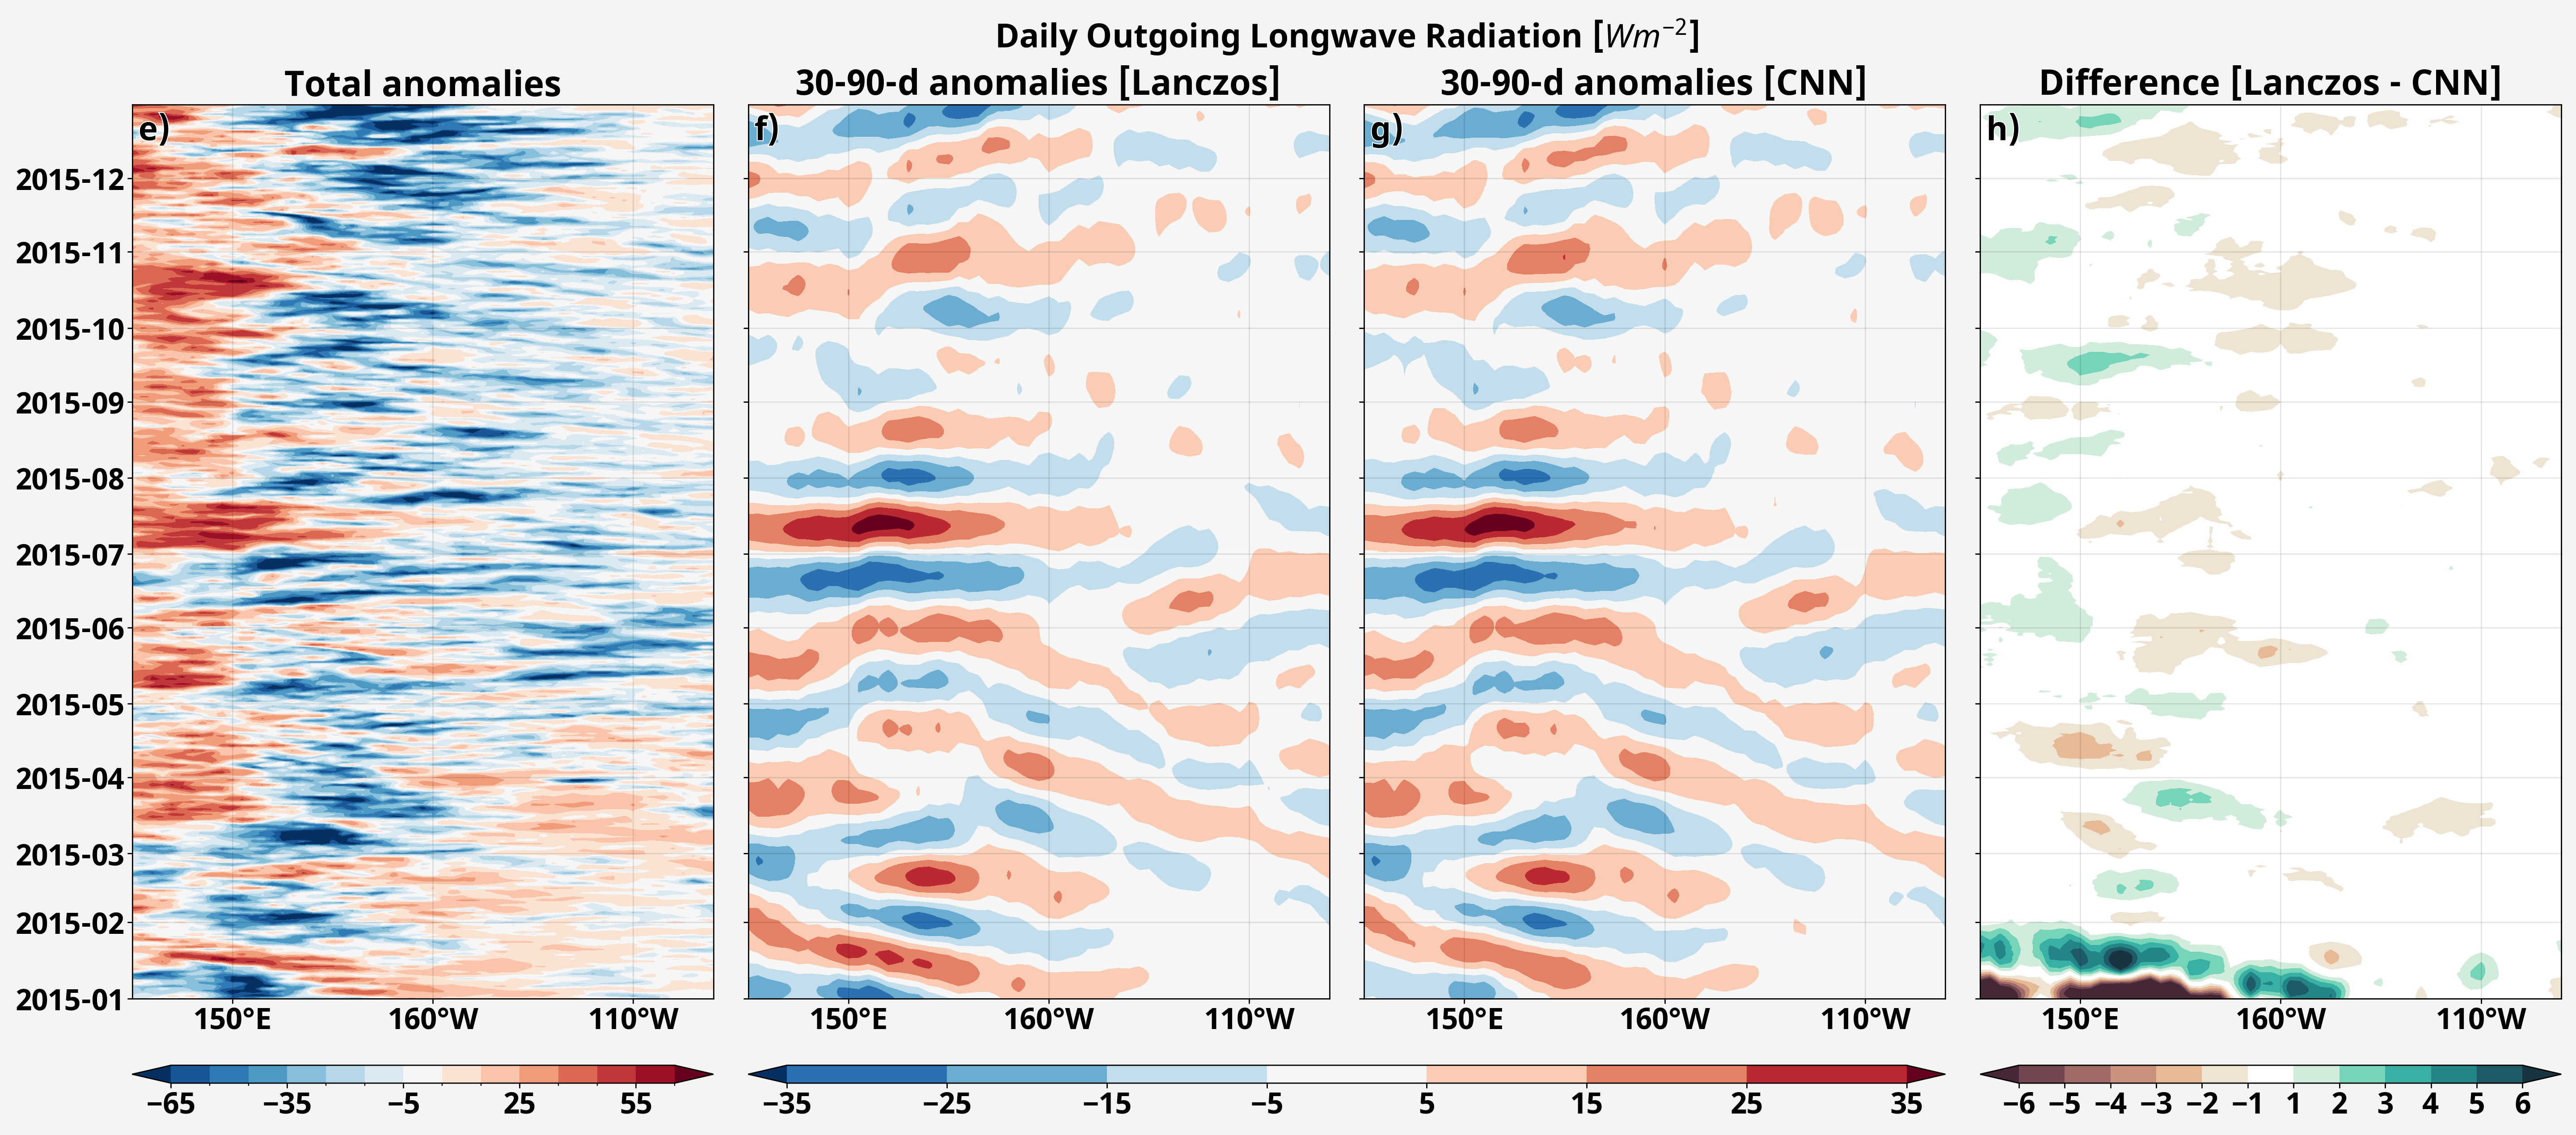

In [11]:
fig, axs = pplt.subplots(nrows=1,ncols=4,refwidth=6.5,refheight=10)

axs.format(xlabel='',ylabel='',xformatter='deglon',xlocator=50,xtickminor=False,ytickminor=False,abc=('e)','f)','g)','h)'),abcloc='ul')

levels1 = [-65,-55,-45,-35,-25,-15,-5,5,15,25,35,45,55,65]
levels2 = [-35,-25,-15,-5,5,15,25,35]
levels3 = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]

im1 = axs[0].contourf(olra_meanlat.sel(time=slice('2015-01-1','2015-12-31')),levels=levels1,extend='both',cmap='RdBu_r',colorbar=False)
im2 = axs[1].contourf(olri_meanlat_lan.sel(time=slice('2015-01-1','2015-12-31')),levels=levels2,extend='both',cmap='RdBu_r',colorbar=False)
axs[2].contourf(olri_meanlat_cnn.sel(time=slice('2015-01-1','2015-12-31')),levels=levels2,extend='both',cmap='RdBu_r',colorbar=False)
im3 = axs[3].contourf(olri_diff.sel(time=slice('2015-01-1','2015-12-31')),levels=levels3,extend='both',cmap='DryWet',colorbar=False)

axs[0].format(title='Total anomalies')
axs[1].format(title='30-90-d anomalies [Lanczos]')
axs[2].format(title='30-90-d anomalies [CNN]')
axs[3].format(title='Difference [Lanczos - CNN]')

fig.colorbar(im1,location='bottom',shrink= 1, width= 0.2,label='',col=1)
fig.colorbar(im2,location='bottom',shrink= 1, width= 0.2,label='',col=(2,3))
fig.colorbar(im3,location='bottom',shrink= 1, width= 0.2,label='',col=4)
fig.suptitle(r'Daily Outgoing Longwave Radiation [$Wm^{-2}$]')

fig.savefig('Fig3b.png',dpi=150)

#### Compute RMSE, IOA, R-squared, and power spectral density for zonal wind stress
The R-squared value will indicate the proportion of variance in the Lanczos band pass filtered anomalies \
that is explained by the predicted band pass filtered anomalies from the CNN model.

In [12]:
# Calcualting the RMSE and Index of Agreement for surface zonal wind stress
rmse = np.zeros(tauxi_meanlat_lan.shape[1])  # RMSE
ia = np.zeros(tauxi_meanlat_lan.shape[1])  # IOA
r2_ws = np.zeros(tauxi_meanlat_lan.shape[1])  # R2-squared

for i in range(tauxi_meanlat_lan.shape[1]):
    rmse[i] = root_mean_squared_error(tauxi_meanlat_lan[:,i], tauxi_meanlat_cnn[:,i])
    r2_ws[i] = r2_score(tauxi_meanlat_lan[:,i], tauxi_meanlat_cnn[:,i])
    ia[i] = index_agreement(tauxi_meanlat_cnn[:,i], tauxi_meanlat_lan[:,i])
    
# Calculating the power spectrum for surface zonal wind stress
f1,psd1 = sig.periodogram(tauxi_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),scaling='density',detrend='linear',fs=1)
f2,psd2 = sig.periodogram(tauxi_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),scaling='density',detrend='linear',fs=1)

r, p = pearsonr(tauxi_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(125,160))
                            .mean('lon'),tauxi_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'))
print(f'The Pearson Correlation Coefficient between Lanczos and CNN filtered taux anomalies: {r}')

The Pearson Correlation Coefficient between Lanczos and CNN filtered taux anomalies: 0.9729109889502701


#### Figure 4

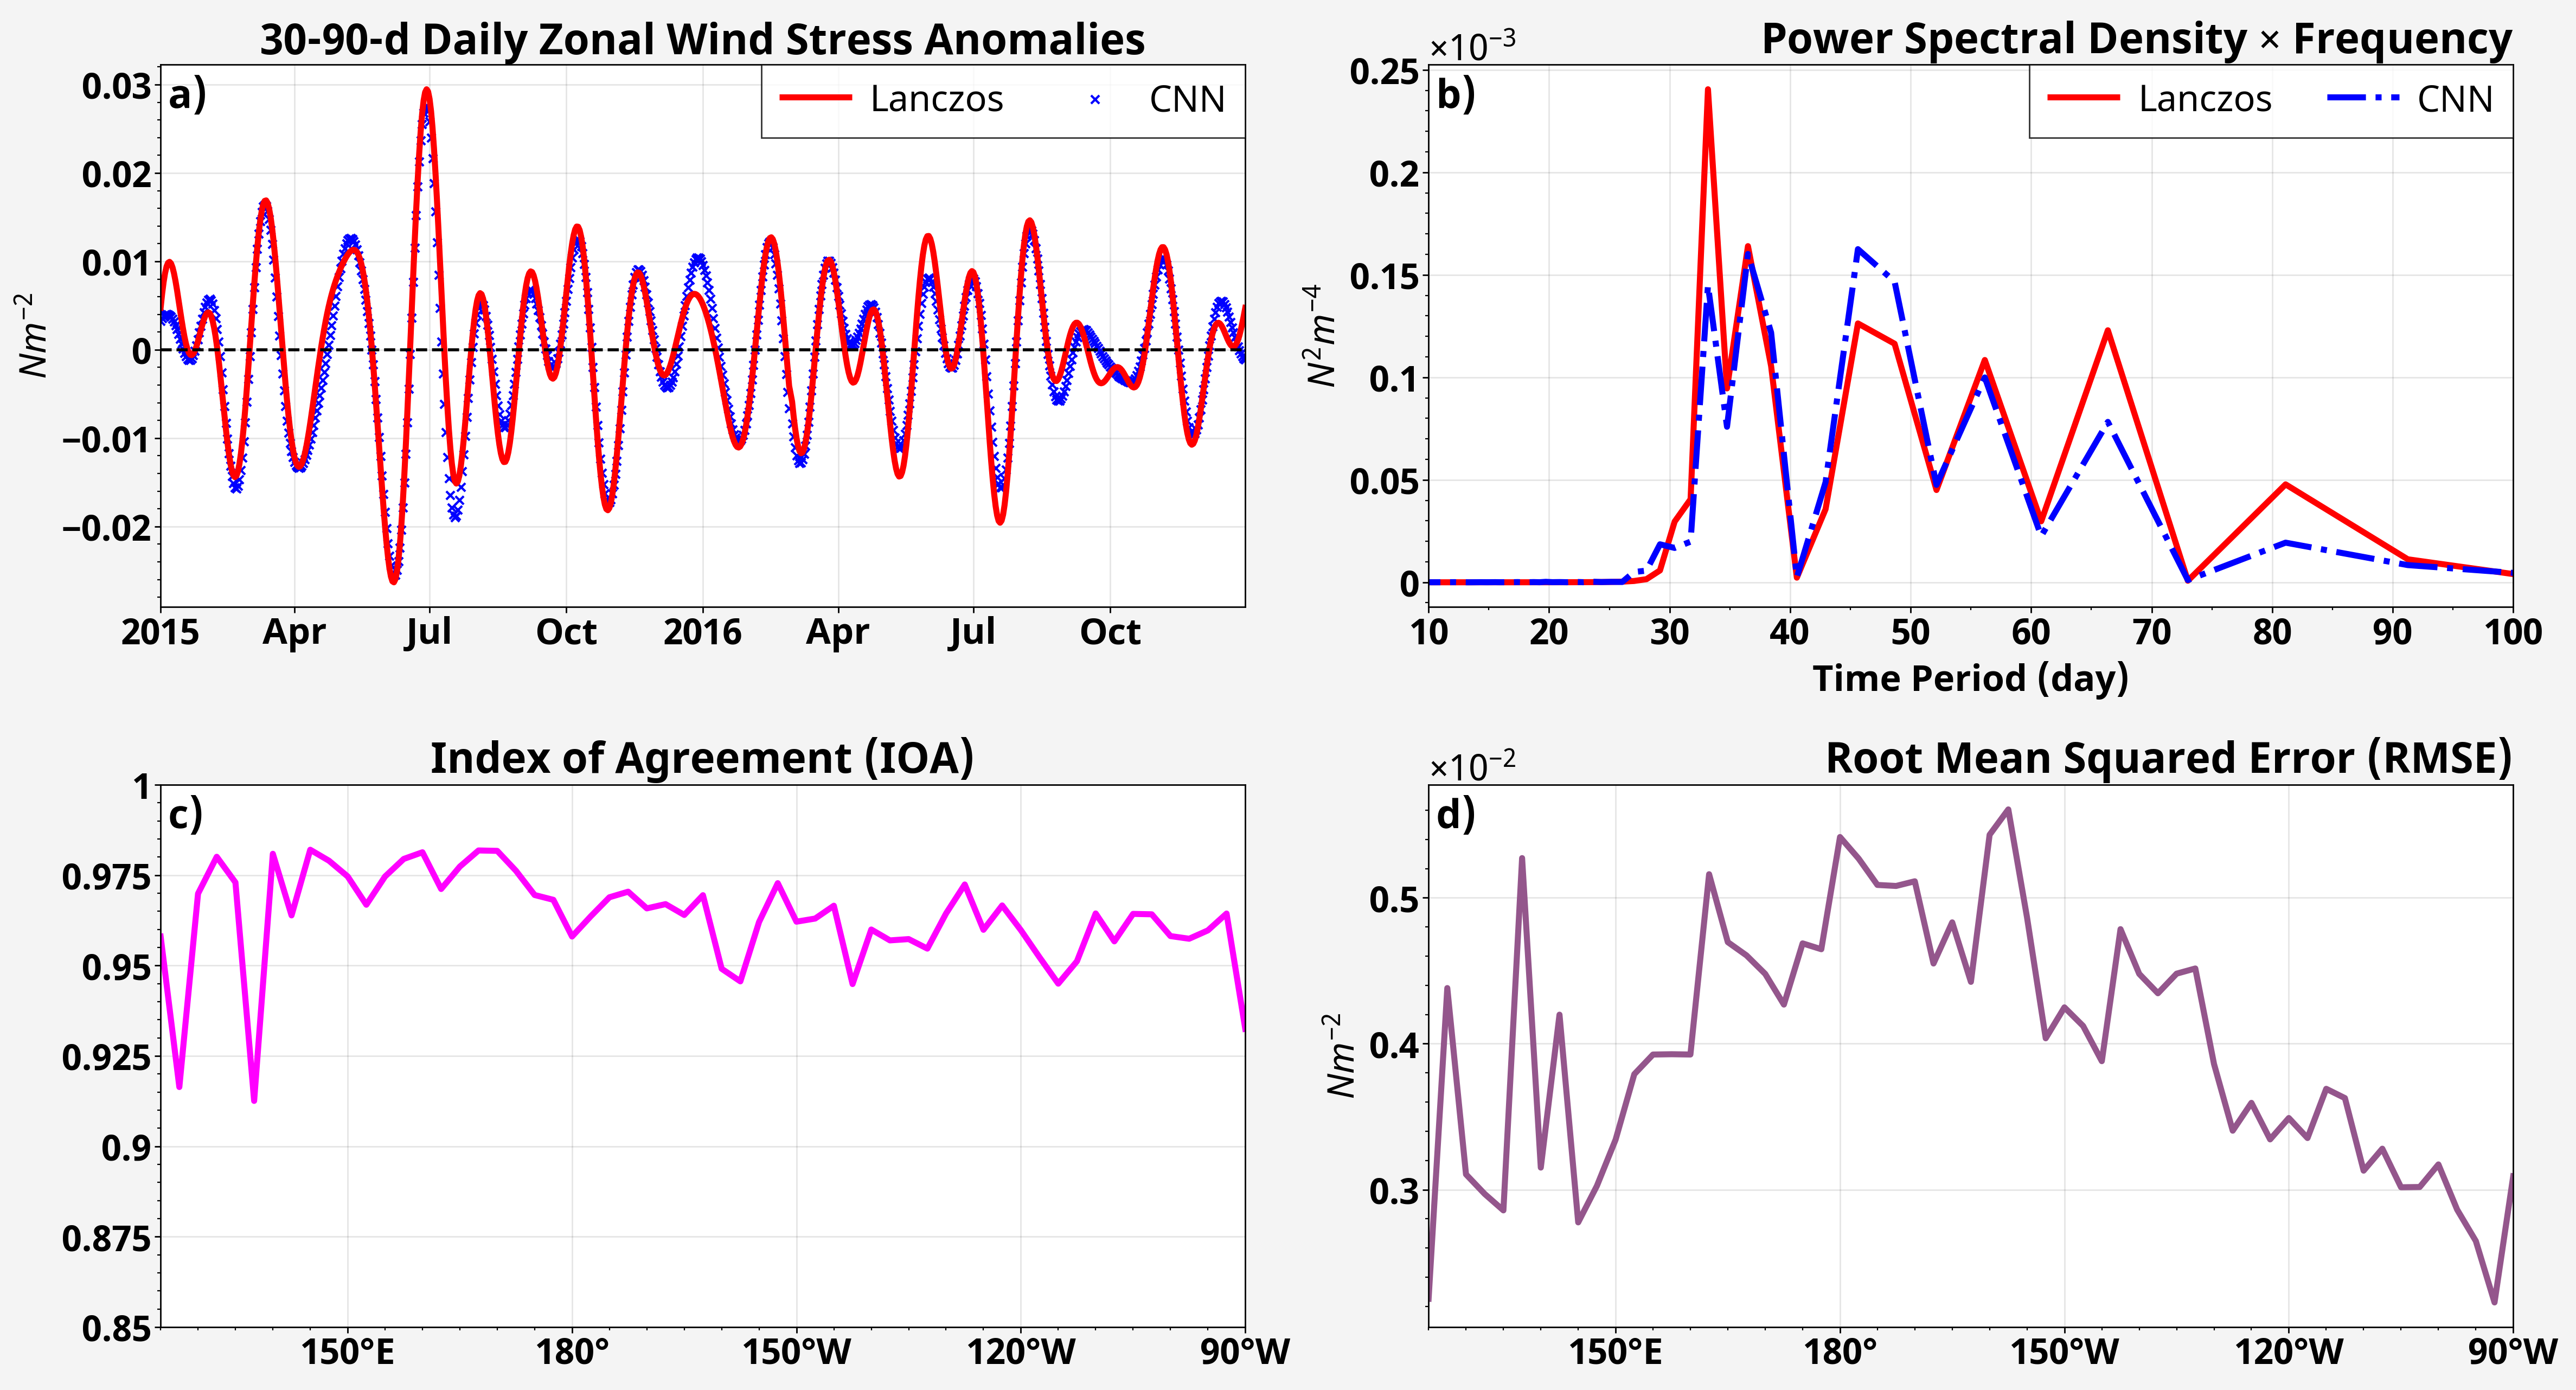

In [13]:
fig, axs = pplt.subplots(nrows=2,ncols=2,refwidth=10,refheight=5,share=0,span=False)
axs.format(abc='a)',abcloc='ul')

axs[0].scatter(tauxi_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),color='b',marker='x',markersize=30,label='CNN')
axs[0].plot(tauxi_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),'r',lw=4,label='Lanczos')
axs[0].format(xformatter='concise',xrotation=0,xminorlocator=('month',4),title='30-90-d Daily Zonal Wind Stress Anomalies',ylabel=r'$Nm^{-2}$',xlabel='')#,xlocator=('month',3))
axs[0].axhline(y=0,color='black',ls='--',lw=2)
axs[0].legend(loc='best')

axs[1].plot(1/f1[7:],f1[7:]*psd1[7:],color='r',lw=4,label='Lanczos')
axs[1].plot(1/f2[7:],f2[7:]*psd2[7:],color='b',lw=4,ls='-.',label='CNN')
axs[1].legend(loc='best')
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
axs[1].format(xlim=(10,100),xlocator=10,xminorlocator=5,rtitle=r'Power Spectral Density $\times$ Frequency',ylabel=r'$N^2m^{-4}$',xlabel='Time Period (day)')

axs[2].plot(tauxi_meanlat_lan.lon.data,ia,lw=4,color='magenta')
axs[2].format(ylim=(0.85,1),xlocator=30,xminorlocator=5,title='Index of Agreement (IOA)',ylabel='',xlabel='',xformatter='deglon')

axs[3].plot(tauxi_meanlat_lan.lon.data,rmse,lw=4,color='purple')
axs[3].ticklabel_format(axis='y', style='sci', scilimits=(-2,-2))
axs[3].format(xlocator=30,xminorlocator=5,rtitle='Root Mean Squared Error (RMSE)',ylabel=r'$Nm^{-2}$',xlabel='',xformatter='deglon')

fig.savefig('Fig4.png',dpi=150)

#### Compute RMSE, IOA, R-squared, and power spectral density for zonal wind stress
The R-squared value will indicate the proportion of variance in the Lanczos band pass filtered anomalies \
that is explained by the predicted band pass filtered anomalies from the CNN model.

In [14]:
# Calcualting the RMSE and Index of Agreement for OLR

rmse = np.zeros(olri_meanlat_lan.shape[1])  # RMSE
ia = np.zeros(olri_meanlat_lan.shape[1])  # IOA
r2_olr = np.zeros(olri_meanlat_lan.shape[1])  # R2-squard

for i in range(olri_meanlat_lan.shape[1]):
    rmse[i] = root_mean_squared_error(olri_meanlat_lan[:,i], olri_meanlat_cnn[:,i])
    r2_olr[i] = r2_score(olri_meanlat_lan[:,i], olri_meanlat_cnn[:,i])
    ia[i] = index_agreement(olri_meanlat_cnn[:,i], olri_meanlat_lan[:,i])

# Calculating the power spectrum for surface zonal wind stress

f1,psd1 = sig.periodogram(olri_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),scaling='density',detrend='linear',fs=1)
f2,psd2 = sig.periodogram(olri_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),scaling='density',detrend='linear',fs=1)

r, p = pearsonr(olri_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),olri_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'))
print(f'The Pearson Correlation Coefficient between Lanczos and CNN filtered OLR anomalies: {r}')

The Pearson Correlation Coefficient between Lanczos and CNN filtered OLR anomalies: 0.9902829768108767


#### Figure 5

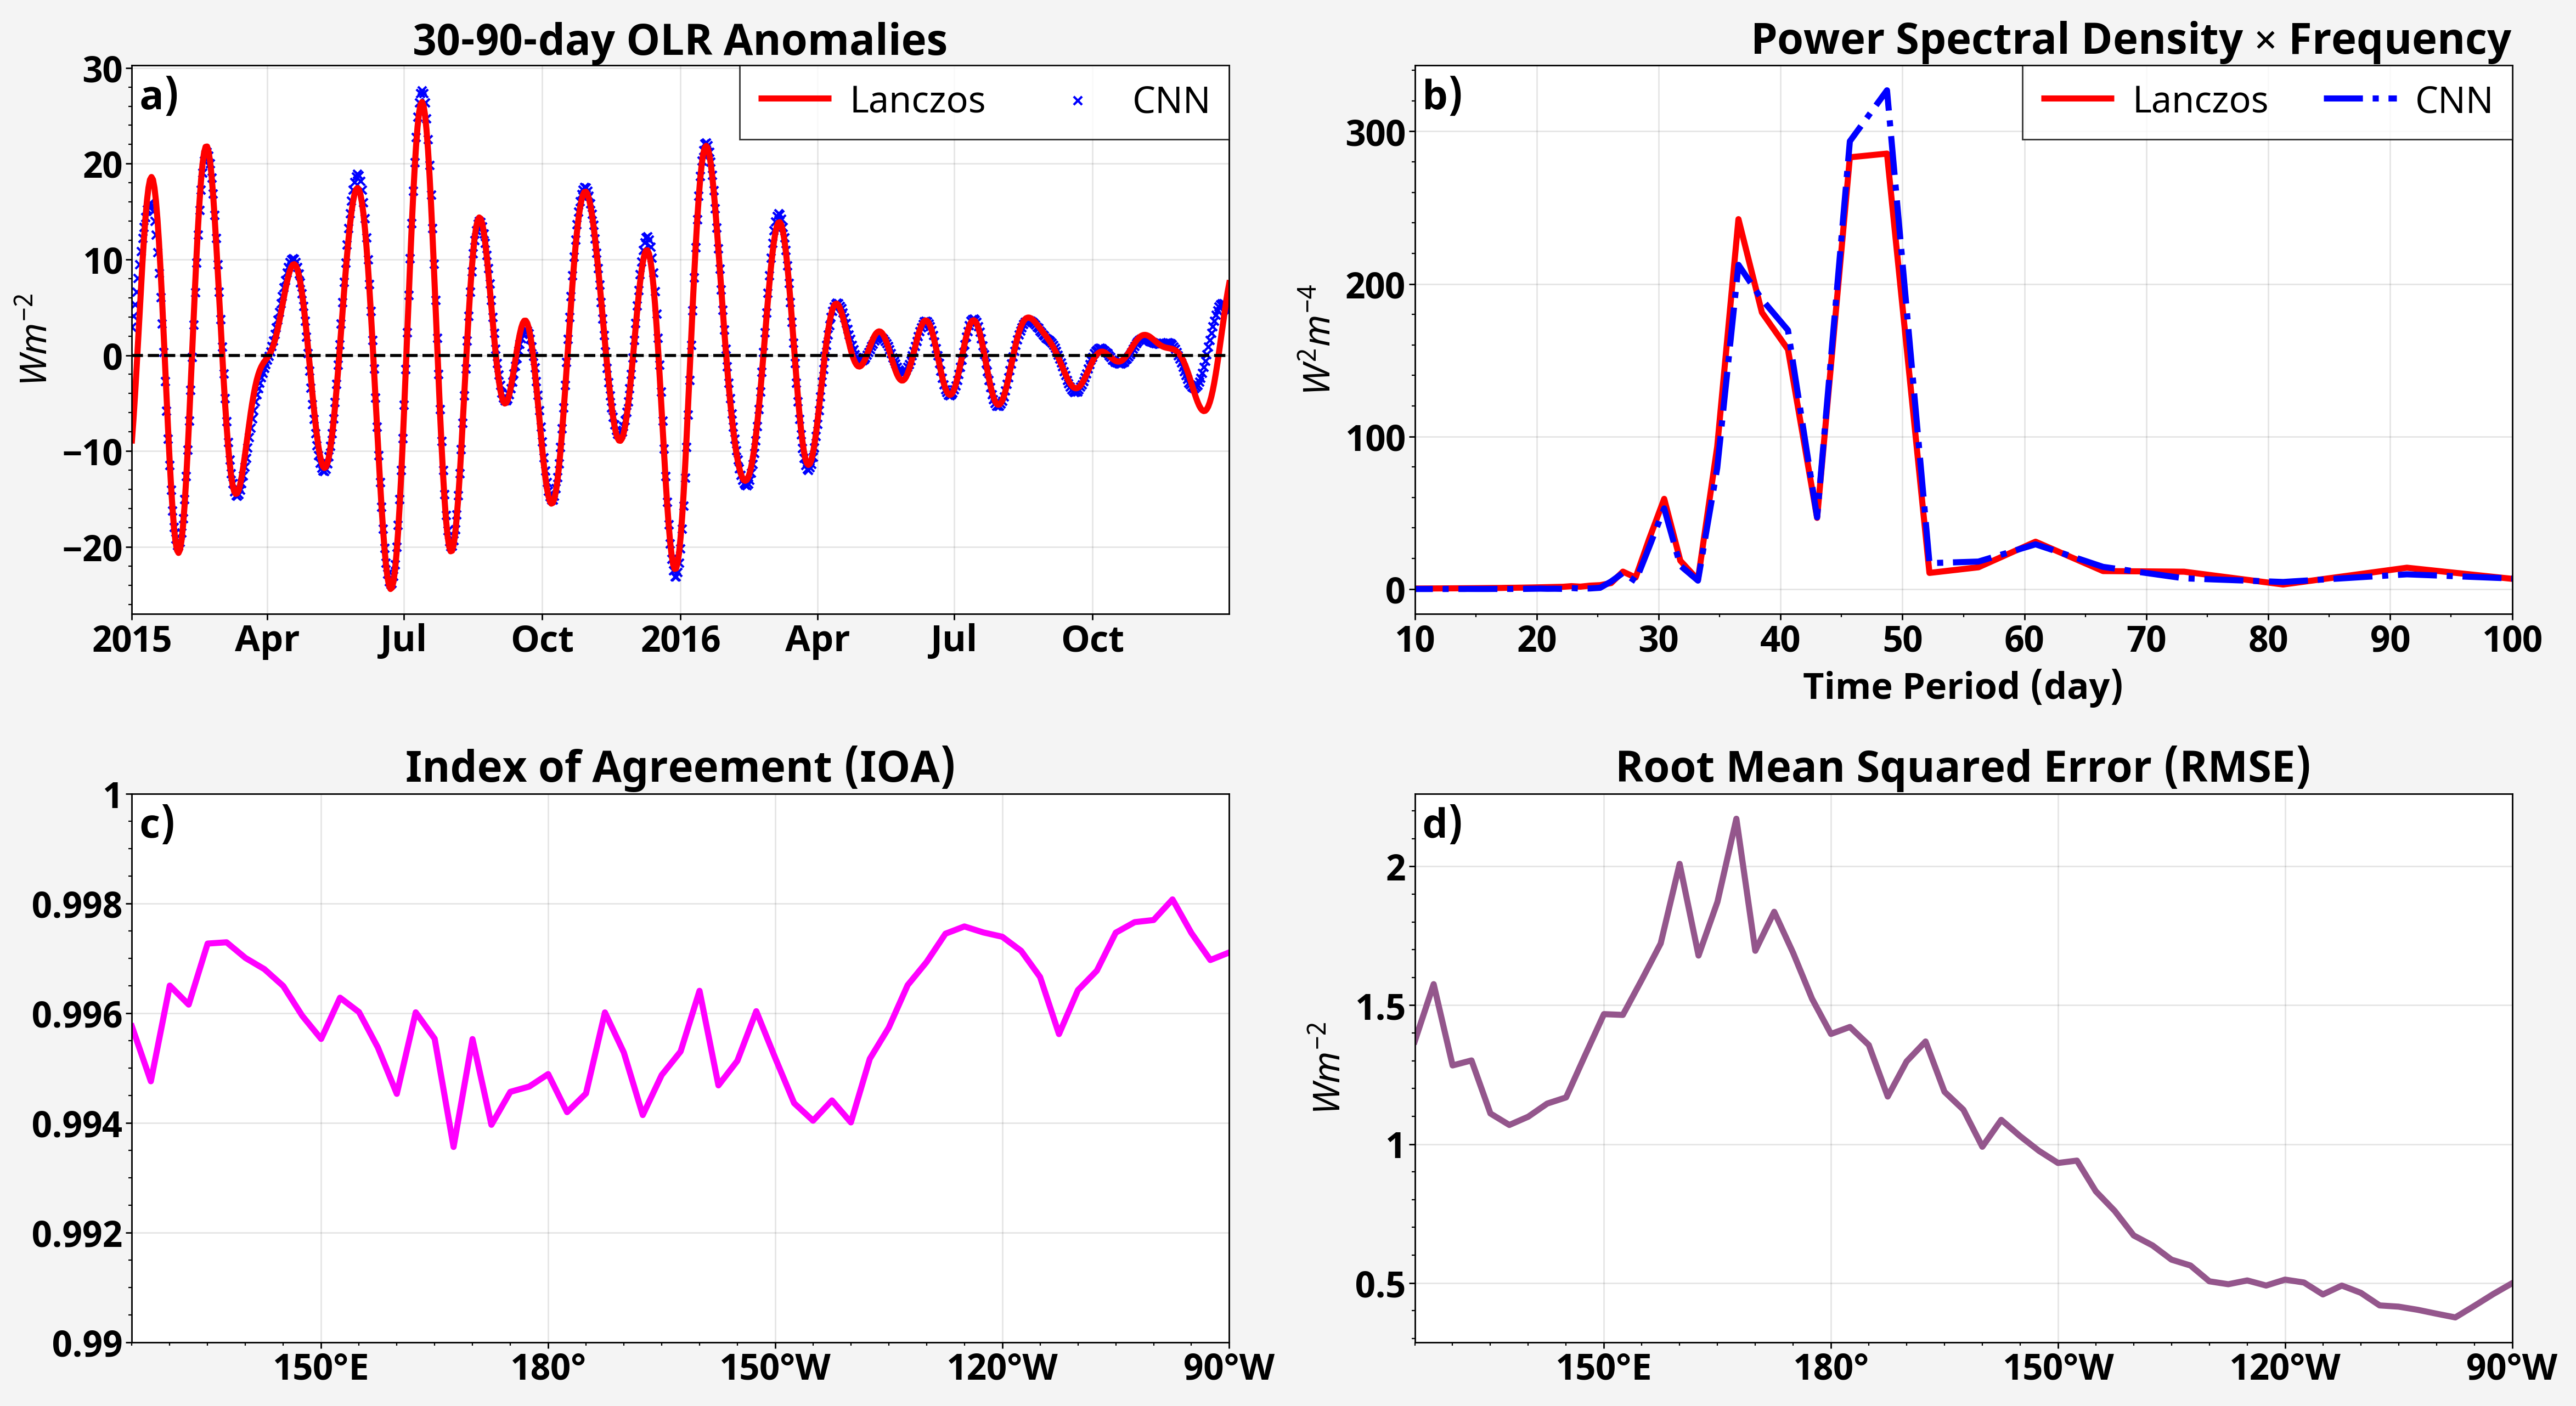

In [15]:
fig, axs = pplt.subplots(nrows=2,ncols=2,refwidth=10,refheight=5,share=0,span=False)
axs.format(abc='a)',abcloc='ul')

axs[0].scatter(olri_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),color='b',marker='x',markersize=30,label='CNN')
axs[0].plot(olri_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),'r',lw=4,label='Lanczos')
axs[0].format(xformatter='concise',xrotation=0,xminorlocator=('month',4),title='30-90-day OLR Anomalies',ylabel=r'$Wm^{-2}$',xlabel='')#,xlocator=('month',3))
axs[0].axhline(y=0,color='black',ls='--',lw=2)
axs[0].legend(loc='best')

axs[1].plot(1/f1[7:],f1[7:]*psd1[7:],color='r',lw=4,label='Lanczos')
axs[1].plot(1/f2[7:],f2[7:]*psd2[7:],color='b',lw=4,ls='-.',label='CNN')
axs[1].legend(loc='best')
axs[1].format(xlim=(10,100),xlocator=10,xminorlocator=5,rtitle=r'Power Spectral Density $\times$ Frequency',ylabel=r'$W^2m^{-4}$',xlabel='Time Period (day)')

axs[2].plot(olri_meanlat_lan.lon.data,ia,lw=4,color='magenta')
axs[2].format(ylim=(0.99,1),xlocator=30,xminorlocator=5,title='Index of Agreement (IOA)',ylabel='',xlabel='',xformatter='deglon')

axs[3].plot(olri_meanlat_lan.lon.data,rmse,lw=4,color='purple')
axs[3].format(xlocator=30,xminorlocator=5,title='Root Mean Squared Error (RMSE)',ylabel=r'$Wm^{-2}$',xlabel='',xformatter='deglon')

fig.savefig('Fig5.png',dpi=150)

#### Figure 6: Coefficient of Determination

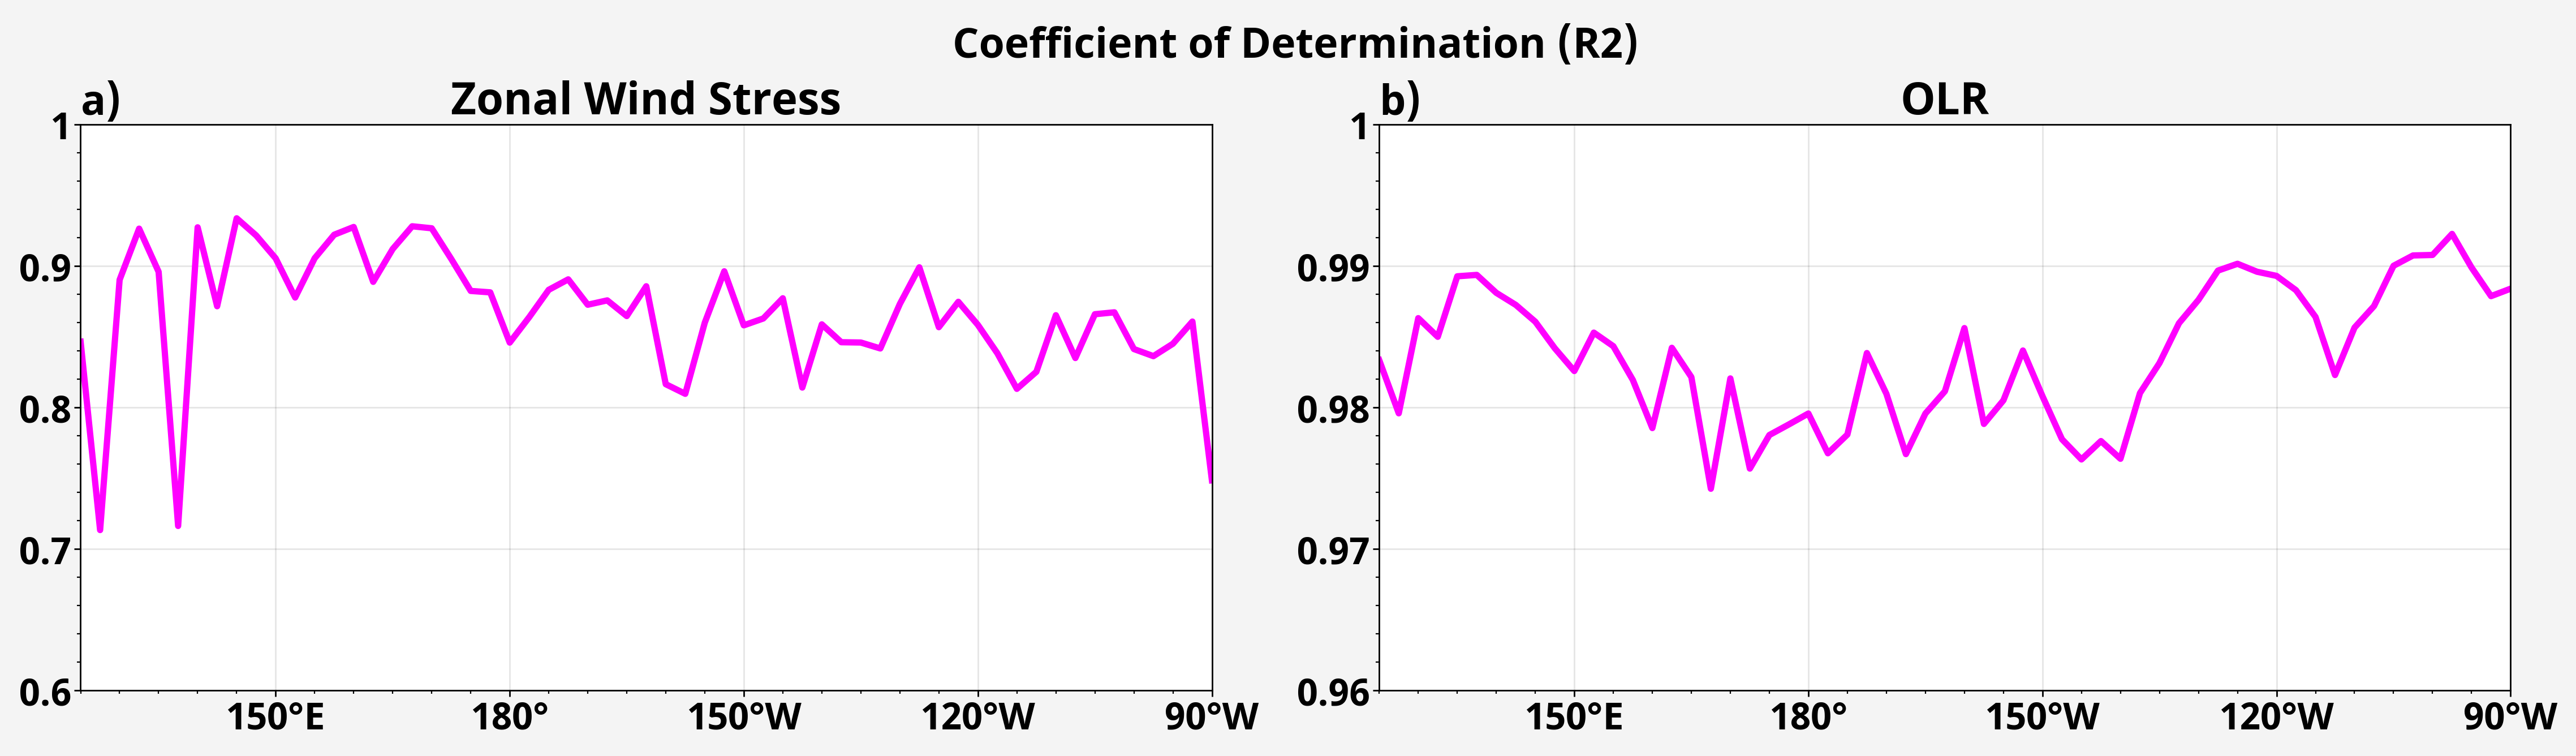

In [16]:
fig, axs = pplt.subplots(nrows=1,ncols=2,refwidth=10,refheight=5,share=0,span=False)
axs.format(abc='a)',abcloc='l')

axs[0].plot(tauxi_meanlat_lan.lon.data,r2_ws,lw=4,color='magenta')
axs[0].format(ylim=(0.6,1),xlocator=30,xminorlocator=5,title='Zonal Wind Stress',ylabel='',xlabel='',xformatter='deglon')

axs[1].plot(olri_meanlat_lan.lon.data,r2_olr,lw=4,color='magenta')
axs[1].format(ylim=(0.96,1),xlocator=30,xminorlocator=5,title='OLR',ylabel='',xlabel='',xformatter='deglon')

fig.suptitle('Coefficient of Determination (R2)');

fig.savefig('Fig6.png',dpi=150)